In [79]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from dataloading import loading as load
from training.nn_models import MLPmodel, CNNmodel, NaiveRNNmodel, num_params
from training.trainer_class import Trainer

In [74]:
def plot_stats(dic, keys, lbls=None, lbl_prepend="", valid_only=False, train_only=False, snr_range=None, 
               lstyle="-", return_c=False):
    # for plotting training statistics
    keys = keys if isinstance(keys, list) else [keys]
    labels = keys if lbls is None else lbls
    for key, lbl in zip(keys, labels):
        train = dic["train"][key] if snr_range is None else dic["train"][snr_range][key]
        valid = dic["valid"][key] if snr_range is None else dic["valid"][snr_range][key]
        p = plt.plot(train, label=lbl_prepend+lbl, linestyle=lstyle) if not valid_only else plt.plot([], label=lbl_prepend+lbl)
        plt.plot(valid, color=p[0].get_color(), linestyle="--" if not valid_only else lstyle) if not train_only else 0
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)
    return p[0].get_color() if return_c else None

def save_trainer_stats(trainer):
    # copies trainer tracked values (loss, accuracies, etc.)
    stats = {s:{"train":{}, "valid":{}} for s in ["losses", "metrics"]}
    splitnames = ["train", "valid"]
    for s in splitnames:
        stats["metrics"][s] = {rng:{} for rng in trainer.snr_ranges}
        for l in trainer.losses[s]:
            stats["losses"][s][l] = [i for i in trainer.losses[s][l]]
        for rng in stats["metrics"][s]:
            for m in trainer.metrics[s][rng]:
                stats["metrics"][s][rng][m] = [i for i in trainer.metrics[s][rng][m]]
    if "test" in trainer.metrics:
        stats["metrics"]["test"] = {rng:{} for rng in trainer.snr_ranges}
        for rng in stats["metrics"]["test"]:
            for m in trainer.metrics["test"][rng]:
                stats["metrics"]["test"][rng][m] = trainer.metrics["test"][rng][m]
    if trainer.lambdas is not None:
        stats["lambdas"] = [i for i in trainer.lambdas]
    stats["grad_norms"] = [i for i in trainer.grad_norms]
    return stats

def save_results(trainer, fname):
    utils.make_dir("results")
    with open("results/"+fname, "wb") as f:
        pickle.dump(save_trainer_stats(trainer), f)
        
def average_stats(stats):
    # in the case for multiple runs
    runs = len(stats)
    stats_mean, stats_std = {}, {}

    grad_norms = [stats[i]["grad_norms"] for i in range(runs)]
    stats_mean["grad_norms"] = np.mean(grad_norms, 0)
    stats_std["grad_norms"] = np.std(grad_norms, 0)

    #metrics
    stats_mean["metrics"], stats_std["metrics"] = {}, {}
    for split in stats[0]["metrics"].keys():
        stats_mean["metrics"][split], stats_std["metrics"][split] = {}, {}
        for rng in stats[0]["metrics"]["train"].keys():
            stats_mean["metrics"][split][rng], stats_std["metrics"][split][rng] = {}, {}
            for m in stats[0]["metrics"]["train"][rng].keys():
                mvals = [stats[i]["metrics"][split][rng][m] for i in range(runs)]
                stats_mean["metrics"][split][rng][m] = np.mean(mvals, 0)
                stats_std["metrics"][split][rng][m] = np.std(mvals, 0)
    #losses
    stats_mean["losses"], stats_std["losses"] = {}, {}
    for split in ["train", "valid"]:
        stats_mean["losses"][split], stats_std["losses"][split] = {}, {}
        for l in stats[0]["losses"]["train"].keys():
            lvals = [stats[i]["losses"][split][l] for i in range(runs)]
            stats_mean["losses"][split][l] = np.mean(lvals, 0)
            stats_std["losses"][split][l] = np.std(lvals, 0)
    return stats_mean, stats_std

In [49]:
# modes: 0:nothing, 1:scale, 2:scale+diff, 3:diff+scale
# nanmodes: 0:nothing, 1:zero-fill, 2:lin_interp

# median scaled here - note: if rnn applied real-world light curve, 
#                            need to take into large deviations from center
train_loader, valid_loader, test_loader = load.get_loaders_fn(train_path="data/nn/sim/train", 
                                          valid_path="data/nn/sim/valid", test_path="data/nn/sim/test",
                                          train_batch=128, valid_batch=1000, mode=1, nanmode=2,
                                          scale_median=1, standardize=1, incl_centr=False)

train500_loader, valid500_loader, test500_loader = load.get_loaders_fn(train_path="data/nn/sim500/train", 
                                                valid_path="data/nn/sim500/valid", test_path="data/nn/sim500/test",
                                                train_batch=128, valid_batch=1000, mode=1, 
                                                nanmode=2, scale_median=1, standardize=1, incl_centr=False)

## Training 
Train each model 3 times for different random seeds, then store the results for analysis.

In [58]:
# # MLP =======================

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = MLPmodel(n_inputs=1500, hidden_units=[128,64,64], neg_slope=0)
#     trainer = Trainer(model, train_loader, valid_loader, mname="mlp")
#     trainer.train(epochs=25, lr=0.005, weight_decay=5e-3)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
# stats_mean, stats_std = average_stats(stats)
# with open("results/mlp_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)


# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = MLPmodel(n_inputs=500, hidden_units=[128,64,64], neg_slope=0)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="mlp")
#     trainer.train(epochs=25, lr=0.005, weight_decay=5e-3)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
# stats_mean, stats_std = average_stats(stats)
# with open("results/mlp_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

  0%|          | 0/25 [00:00<?, ?it/s]

params: 204609


100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


In [80]:
# # CNN =======================

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = CNNmodel(1500, channels=[4,12,1], kernels=[7,7,3],
#                strides=[1,1,1], fc_hiddens=[48], pool=3, batch_norm=True, info=False)
#     trainer = Trainer(model, train_loader, valid_loader, mname="cnn")
#     trainer.train(epochs=25, lr=0.006, weight_decay=1e-4)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
# stats_mean, stats_std = average_stats(stats)
# with open("results/cnn_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = CNNmodel(500, channels=[4,12,1], kernels=[7,7,3],
#                strides=[1,1,1], fc_hiddens=[48], pool=3, batch_norm=True, info=False)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="cnn")
#     trainer.train(epochs=25, lr=0.006, weight_decay=1e-4)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
# stats_mean, stats_std = average_stats(stats)
# with open("results/cnn_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

  0%|          | 0/25 [00:00<?, ?it/s]

54 inputs left after conv layers
params: 3140


100%|██████████| 25/25 [01:46<00:00,  4.25s/it]


In [ ]:
# # NaiveRNN =======================

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = NaiveRNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
#     trainer = Trainer(model, train_loader, valid_loader, mname="rnn_naive")
#     trainer.train(epochs=25, lr=0.008, weight_decay=1e-4)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/rnn_naive_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = NaiveRNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="rnn_naive")
#     trainer.train(epochs=25, lr=0.008, weight_decay=1e-4)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/rnn_naive_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

In [ ]:
# # RNN =======================

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = nn_models.RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
#     trainer = Trainer(model, train_loader, valid_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/bigru1_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = nn_models.RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=2)
#     trainer = Trainer(model, train_loader, valid_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/bigru2_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = nn_models.RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=False, num_layers=1)
#     trainer = Trainer(model, train_loader, valid_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/gru1_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = nn_models.RNNmodel(64, [64,64], neg_slope=0, lstm=True, bidirectional=True, num_layers=1)
#     trainer = Trainer(model, train_loader, valid_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/bilstm1_sim.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# # ========================================================

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/bigru1_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=2)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/bigru2_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=False, num_layers=1)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/gru1_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

# stats = []
# for i in range(3):
#     torch.manual_seed(i), np.random.seed(i) 
#     model = RNNmodel(64, [64,64], neg_slope=0, lstm=True, bidirectional=True, num_layers=1)
#     trainer = Trainer(model, train500_loader, valid500_loader, mname="rnn")
#     trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)
#     trainer.get_test_results(test500_loader)
#     stats.append(save_trainer_stats(trainer))
#     stats_mean, stats_std = average_stats(stats)
# with open("results/bilstm1_sim500.pkl", "wb") as f:
#     pickle.dump({"mean":stats_mean, "std":stats_std}, f)

In [ ]:
rnnw = nn_models.RNNmodel(64, [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
rnnw_trainer = Trainer(rnnw, train_loader, valid_loader, mname="rnn")
print("params:", num_params(rnnw))
rnnw_trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=4, snr_weight="snr")

In [ ]:
rnn_conf = nn_models.ConfidenceRNNmodel(64, [64,64], [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
rnn_conf_trainer = Trainer(rnn_conf, train_loader, valid_loader, mname="rnn_conf")
print("params:", num_params(rnn_conf))
rnn_conf_trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)

In [ ]:
rnn_gen = nn_models.GenerativeRNNmodel(64, [64,64], [64,64], neg_slope=0, lstm=False, bidirectional=True, num_layers=1)
rnn_gen_trainer = Trainer(rnn_gen, train_loader, valid_loader, mname="rnn_gen")
print("params:", num_params(rnn_gen))
rnn_gen_trainer.train(epochs=25, lr=0.008, weight_decay=5e-5, transit_weight=None, snr_weight=None)

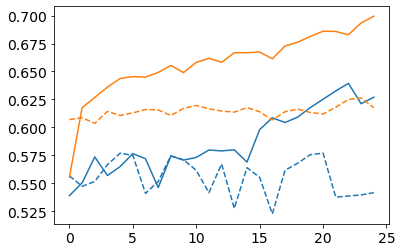

In [81]:
plot_stats(mlp_trainer.metrics, ["acc"], snr_range=())
plot_stats(cnn_trainer.metrics, ["acc"], snr_range=())